In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

In [7]:
import scienceplots
plt.style.use(['science', 'notebook'])

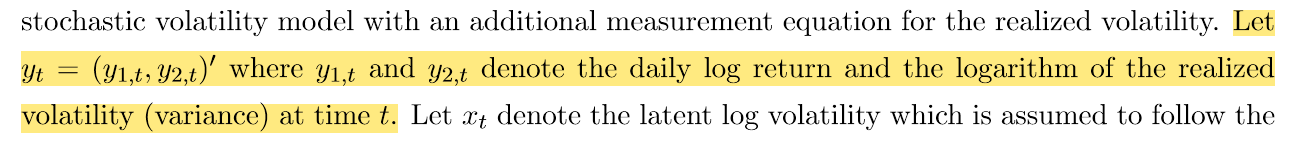

## Data processing

In [ ]:
spy_closes = pd.read_csv("data/1_min_SPY_2008-2021.csv")
spy_closes = spy_closes[['date', 'close']]
spy_closes.loc[:, 'log_return_'] = spy_closes.loc[:, 'close'].apply(np.log).diff()
spy_closes.loc[:, 'return_'] = spy_closes.loc[:, 'close'].diff()

In [ ]:
spy_closes.date = pd.to_datetime(spy_closes.date, format='%Y%m%d  %H:%M:%S')
spy_closes = spy_closes.set_index('date')
spy_closes = spy_closes.resample('D').apply(list)

In [ ]:
spy_closes.loc[:, 'log_return'] = spy_closes.loc[:, 'log_return_'].apply(lambda x: np.sum(x))
spy_closes.loc[:, 'log_real_vol'] = spy_closes.loc[:, 'return_'].apply(lambda x: np.log(np.sum(np.square(x))) if len(x) > 0 else np.nan)
spy_closes.loc[:, 'close'] = spy_closes.loc[:, 'close'].apply(lambda x: x[-1] if len(x) > 0 else np.nan)
spy_closes = spy_closes.dropna().drop(columns=['log_return_', 'return_'])

In [ ]:
spy_closes[['log_return', 'log_real_vol']].tail(500).plot(figsize=(20, 5), style=['rs-', 'bs-'], linewidth=1)

## Implementation

In [ ]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists
from tqdm.notebook import tqdm

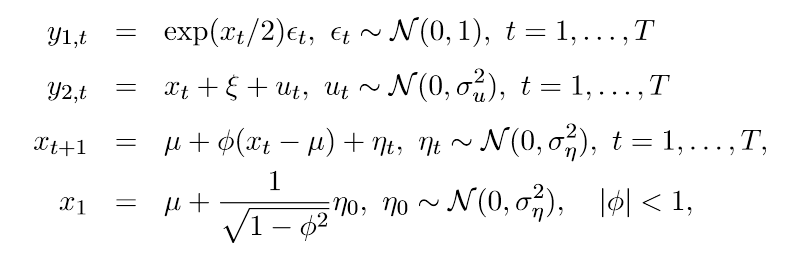

In [ ]:
y = ![image.png](attachment:image.png)spy_closes[['log_return', 'log_real_vol']].to_numpy()

## Import y

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

In [ ]:
import scienceplots
plt.style.use(['science', 'notebook'])

In [ ]:
y = pd.read_pickle('y.pck').to_numpy()

In [ ]:
from scipy.stats import invwishart
import numba

class InvWishart(dists.ProbDist):
    """Inverse Gamma(a,b) distribution."""

    def __init__(self, r=1.0, S=1.0):
        self.r = r
        self.S = S

    def rvs(self, size=None):
        return invwishart.rvs(self.r, self.S, size=size)

    def logpdf(self, x):
        x = np.dot(x.reshape(2, 2).T, x.reshape(2, 2))
        return invwishart.logpdf(x, self.r, scale=self.S)


class RSVModel(ssm.StateSpaceModel):
        
    def extract_params(self):
        
        
        self.Sig = (self.Sig+self.Sig.T)/2
        self.phi = 2*self.omega - 1
        self.sig_eps = np.sqrt(abs(self.Sig[0, 0]))
        self.mu = 2*np.log(self.sig_eps)
        self.xi = self.c - self.mu
        self.sig_eta = np.sqrt(abs(self.Sig[1, 1]))
        self.rho = self.Sig[1, 0]/(self.sig_eps*self.sig_eta)
                

    def PX0(self):  
        self.extract_params()
        return dists.Normal(loc=self.mu, scale=self.sig_eta*(1-self.phi**2)**(-.5))  # X_0 ~ N(0, 1)
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        self.extract_params()
        return dists.Normal(loc=self.mu + self.phi*(xp-self.mu), scale=self.sig_eta)  # X_t ~ N( X_{t-1}, 1)
    
    def PY(self, t, xp, x):
        self.extract_params()
        N = len(x)
        cov_ = np.zeros((N, 2, 2))
        sig_u_squared = self.sig_u**2

        loc_ = np.vstack([np.zeros_like(x), x + self.xi]).T   

        self.build_cov_matrix(cov_, x, sig_u_squared)

        cov_ = np.nan_to_num(cov_, copy=True, nan=1.0)
        loc_ = np.nan_to_num(loc_, copy=True, nan=1.0)
        
        return dists.VaryingCovNormal(loc=loc_, cov=cov_)

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def build_cov_matrix(cov_, x, sig_u_squared):
        N = len(x)
        for n in numba.prange(N):
            cov_[n, :, :] = np.array([[np.exp(float(x[n])/2), 0], [0, sig_u_squared]])


In [ ]:
my_model = RSVModel(**rsv_args)
x, y = my_model.simulate(500)

### Simulations

In [ ]:
my_pmmh.fk_cls.summary_format(my_pmmh.fk_cls, my_pmmh.smc_cls)

In [ ]:
simulations_y = pd.DataFrame(np.array(y).reshape(500, 2))

In [ ]:
chain.plot()

In [ ]:
simulations_y.plot(figsize=(20, 5), style=['rs-', 'bs-'], linewidth=1)

### Bayesian Inference using MCMC 
*(not required but just for testing the particles library)*

In [ ]:
from particles import mcmc

#### Defining our priors

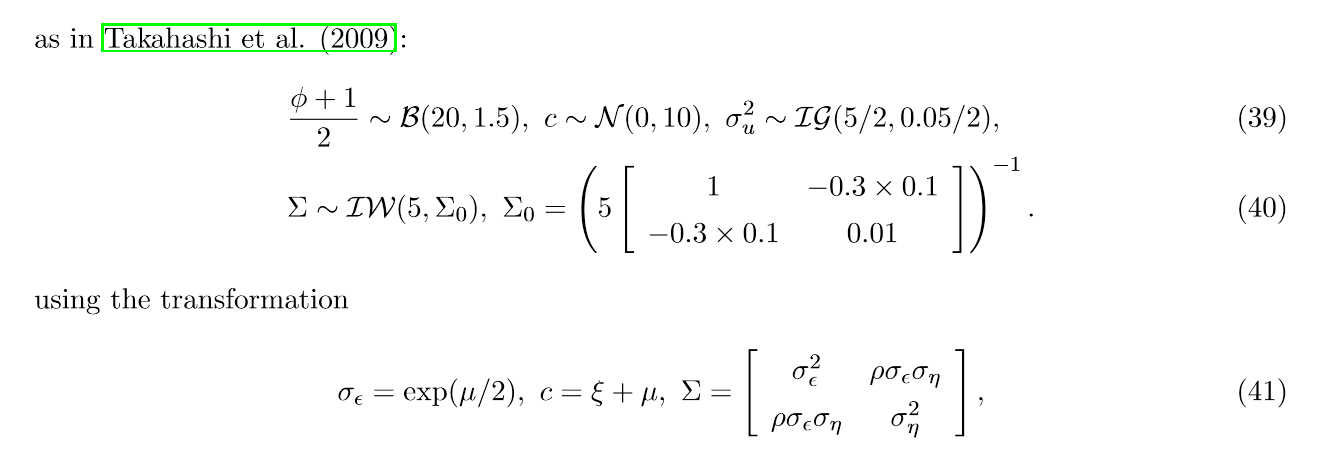

In [ ]:
Sig_0 = np.linalg.inv(5*np.array([[1, -.3*.1], [-.3*.1, 1]]))

prior_dict = {'omega':dists.Beta(20, 1.5),
              'c': dists.Normal(0, 10),
              'sig_u':dists.InvGamma(5/2, .05/2),
              'Sig': InvWishart(5, Sig_0)
             }

prior_dict['Sig'].dim = (2, 2)

my_prior = dists.StructDist(prior_dict)

In [ ]:
from particles.core import *

In [ ]:
rsv_args = my_prior.rvs(1)[0]

In [ ]:
smc_options = {'store_history':True}

In [ ]:
T = 20

my_pmmh = mcmc.PMMH(ssm_cls=RSVModel, prior=my_prior, data=y, Nx=100,
                    niter=100, verbose=0, adaptive=True, smc_options=smc_options)

my_pmmh.run()

In [ ]:
chain = pd.DataFrame(my_pmmh.chain.theta.tolist()).iloc[:105]

In [ ]:
pd.DataFrame(list(my_pmmh.smcs))

<Axes: >

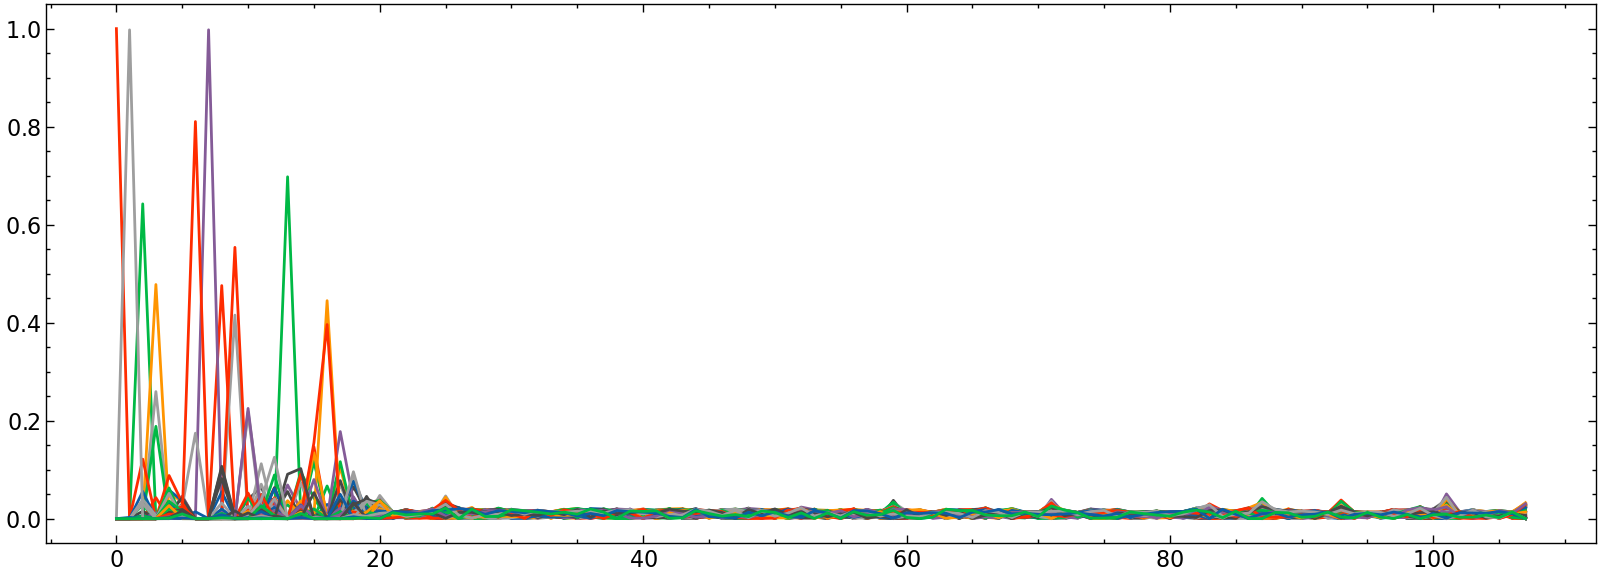

In [31]:
pd.DataFrame(map(lambda x: x.wgts.W, my_pmmh.smcs)).plot(figsize=(20, 7), legend=False)

In [27]:
def is_spd(matrix):
    return np.all(np.linalg.eigvals(np.array(matrix)) > 0)

In [33]:
rsv_args = chain.iloc[-1].to_dict()